# __WSI - ćwiczenie 4.__

### __Regresja i klasyfikacja__

#### __Treść ćwiczenia__

- Celem ćwiczenia jest implementacja drzew decyzyjnych tworzonych algorytmem _ID3_ z ograniczeniem maksymalnej głębokości drzewa.
- Następnie należy wykorzystać stworzony algorytm do stworzenia i zbadaniajakości klasyfikatorów dla zbioru danych breast cancer (https://archive.ics.uci.edu/ml/datasets/breast+cancer). Klasą jest poleirradiat.
- Należy pamiętać o podziale danych na zbiory trenujący, walidacyjny i testo-wy. Można użyć w tym celu gotowych funkcji.

In [107]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, PrecisionRecallDisplay, recall_score, precision_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from seaborn import heatmap
import plotly.express as px
from math import log, inf


RNG = np.random.default_rng()

%autoreload 

UsageError: Line magic function `%autoreload` not found.


#### __Ładowanie danych__

In [108]:

columns = ['class', 'age', 'menopause', 'tumor-size', 'inv-nodes', 
           'node-caps', 'deg-malig', 'breast', 'breast-quad', 'irradiat']
data = pd.read_csv('./data/breast-cancer.data', header=None, names=columns)

In [109]:
data.head()

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


In [110]:
data.value_counts()

class                 age    menopause  tumor-size  inv-nodes  node-caps  deg-malig  breast  breast-quad  irradiat
no-recurrence-events  60-69  ge40       15-19       0-2        no         2          right   left_up      no          2
                      40-49  premeno    10-14       0-2        no         1          right   left_up      no          2
                      60-69  ge40       20-24       0-2        no         1          left    left_low     no          2
                      50-59  premeno    25-29       0-2        no         2          left    left_low     no          2
                      40-49  premeno    20-24       0-2        no         2          right   left_up      no          2
                                                                                                                     ..
                      50-59  ge40       20-24       3-5        yes        2          right   left_up      no          1
                                        25-29

In [111]:
data['irradiat'].value_counts()

no     218
yes     68
Name: irradiat, dtype: int64

In [112]:
data['node-caps'].value_counts()

no     222
yes     56
?        8
Name: node-caps, dtype: int64

#### __Usuwanie nieznanych wartości__

In [113]:
data.drop(data.loc[data['node-caps'] == '?'].index, inplace=True)

#### __Podział na zbiór trenujący i testowy__

Świadomie wybieram podział na dwa podzbiory: train i test, ponieważ nie będę stroił hiperparametrów. Spodziewam się tak płytkich drzew, że badać je będę zapewne na maksymalnej możliwej głębokości. W dodatku dataset jest bardzo mały i niezbilansowany. Podział na jeden dodatkowy podzbiór zmniejszyłby możliwości szkoleniowe i testowe dwóch pozostałych.

In [114]:
RANDOM_STATE=34
PRED_LABEL = 'irradiat'
x, y = data.drop(PRED_LABEL, axis=1), data[PRED_LABEL]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_STATE)
train = pd.concat([x_train, y_train], axis=1)
test = pd.concat([x_test, y_test], axis=1)

#### __Prosty model testowy__

In [115]:
class PrimitiveModel():
    def __init__(self) -> None:
        pass

    def fit(self, x, y):
        pass

    def predict(self, x):
        return ['no' for _ in range(len(x))]

In [116]:
model = PrimitiveModel()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
acc = accuracy_score(y_test, y_pred)
print(acc)

0.8035714285714286


#### __Implementacja klasyfikatora _ID3___

Istnieje kilka wariacji implementacji modułu obsługi podziału węzłów na gałęzie. Pierwszy z nich zakłada podanie zbioru wartości atrybutów wejściowych z góry, wtedy nawet jeśli w zbiorze treningowym nie ma krotek zawierających wszystkie permutacje wartości atrybutów, model stworzy odpowiednie gałęzie. Pozostaje jednak problem jak sklasyfikować powstałe w ten sposób węzły, skoro nie mamy odpowiedniej krotki. Wówczas możemy wybrać sposób podziału warunkowego, względem wybranej przez nas zasady podziału, na przykład nierówności (S1 dla x > p, S2 dla x < p dla wybranego p). Możemy też dzielić atrybuty na dwa podzbiory, pierwszy jednoelementowy zawierający tylko atrybuty o największym zysku informacyjnym i drugi zawierający wszystkie pozostałe atrybuty. Tę wariację można też zaimplementować zgodnie z drugą ideą, czyli nie podając zbioru wartości atrybutów. Zmniejsza to jednak znacznie pojemność modelu, i jego performance jest bardzo słaby.

#### __Wariacja wielowartościowa__

In [117]:
class Node():
    def __init__(self, label = None, branches: dict = None, value=None, class_cardinality=0) -> None:
        self.label = label
        self.value = value
        self.branches = branches
        self.class_cardinality = class_cardinality

    def __repr__(self, level=0, path=''):
        output = "\t" * level
        if path:
            output += str(path) + ' -> '
        if self.value is not None:
            output += str(self.value)
        else:
            output += str(self.label)
        output += "\n"
        if self.branches:
            for path, node in self.branches.items():
                output += node.__repr__(level+1, path)
        return output

class ID3_v1():
    def __init__(self, max_depth:int=inf) -> None:
        self._root = None
        self._max_depth = max_depth

    def __repr__(self):
        return self._root.__repr__()

    def fit(self, data, y_column_name):

        def split(data, target_feature):
            values = data[target_feature].unique().tolist()
            return {feature_value:data[data[target_feature] == feature_value] for feature_value in values}

        def entropy(data, y_column_name):
                return -sum([c/data.shape[0]*log(c/data.shape[0]) for c in data[y_column_name].value_counts().to_list()])
        
        def weighted_entropy(data, y_column_name, target_feature):
                return sum([subset.shape[0]/data.shape[0]*entropy(subset, y_column_name) for subset in split(data, target_feature).values()])

        def inf_gain(data, y_column_name, target_feature):
            return entropy(data, y_column_name) - weighted_entropy(data, y_column_name, target_feature)

        def recurr(data: pd.DataFrame, y_column_name: str, features: set, depth:int=0):
            """
            Recursive method which allows the algorithm to create a decision
            tree, which later will be used to predict value in the given dataset.

            Args:
                data:
                y_column_name:
                features:

            Returns:
                root of the decision tree, the nodes of which
                have the following attributes:
                - label - the value of the attribute the split was made on
                - value - output feature value in case the node is terminal
                - branches - dictionary of the following: keys = attribute values,
                  values = nodes
                - (only in binary split variation) class_cardinality - the amount
                  of class instances upon wchich the node was created

            Raises:
                None
            """

            # check end conditions

            # if all instances represent the same class,
            # return leaf with the class label
            if (data[y_column_name] == data[y_column_name].iat[0]).all():
                return Node(value=data[y_column_name].iat[0])
            # if no features are left to split on,
            # return leaf with most frequently occuring class
            if not features or depth >= self._max_depth:
                return Node(value=data[y_column_name].value_counts().idxmax())

            # calculate information gain and choose best feature
            target_feature = max(features, key=lambda f: inf_gain(data, y_column_name, f))
            # split the branch
            data_split = split(data, target_feature).items()
            features.remove(target_feature)
            return Node(target_feature, class_cardinality=data.shape[0], branches={feature_value:recurr(branch, y_column_name, features, depth+1) for feature_value, branch in data_split})

        # initiate feature set
        features = set(data.columns.tolist())
        features.remove(y_column_name)
        self._root = recurr(data, y_column_name, features)

    def feed_through(self, data_case):
        node = self._root
        while not node.value:
            value = data_case[node.label]
            # if value doesnt have a branch representing it 
            if value not in node.branches.keys():
                # choose a branch with the most cardinality
                node = max(node.branches.values(), key=lambda b: b.class_cardinality)
            else:
                node = node.branches[data_case[node.label]]
        return node.value

    def predict(self, data):
        return data.apply(self.feed_through, axis=1)

#### __Wariacja binarna__

__WADA IMPLEMENTACYJNA:__ nazwa atrybutu nie może być 'rest'

In [118]:
class ID3_v2():
    def __init__(self, max_depth:int=inf) -> None:
        self._root = None
        self._max_depth = max_depth

    def __repr__(self):
        return self._root.__repr__()

    def fit(self, data, y_column_name):

        def entropy(data, y_column_name):
            return -sum([c/data.shape[0]*log(c/data.shape[0]) for c in data[y_column_name].value_counts().to_list()])
        
        def weighted_entropy(data, data_subsets, y_column_name):
            return sum([subset.shape[0]/data.shape[0]*entropy(subset, y_column_name) for subset in data_subsets])

        def inf_gain(data, data_subsets, y_column_name):
            return entropy(data, y_column_name) - weighted_entropy(data, data_subsets, y_column_name)
        
        def split(data, target_feature, target_feature_value):
            return data[data[target_feature] == target_feature_value], data[data[target_feature] != target_feature_value]
            

        def recurr(data: pd.DataFrame, y_column_name: str, features: set, depth:int=0):
            """
            Recursive method which allows the algorithm to create a decision
            tree, which later will be used to predict value in the given dataset.

            Args:
                data:
                y_column_name:
                features:

            Returns:
                root of the decision tree, the nodes of which
                have the following attributes:
                - label - the value of the attribute the split was made on
                - value - output feature value in case the node is terminal
                - branches - dictionary of the following: keys = attribute values,
                  values = nodes
                - (only in binary split variation) class_cardinality - the amount
                  of class instances upon wchich the node was created

            Raises:
                None
            """

            # check end conditions

            # if all instances represent the same class,
            # return leaf with the class label
            if (data[y_column_name] == data[y_column_name].iat[0]).all():
                return Node(value=data[y_column_name].iat[0])
            # if no features are left to split on,
            # return leaf with most frequently occuring class
            if not features or depth >= self._max_depth:
                return Node(value=data[y_column_name].value_counts().idxmax())

            split_pairs= []
            for f in features:
                for v in data[f].unique().tolist():
                    split_pairs.append((f, v))
            # calculate information gain and choose best feature
            tmp = [(split(data, *pair), *pair) for pair in split_pairs]
            best_split, target_feature, target_feature_value = max(tmp, key=lambda t: inf_gain(data, t[0], y_column_name))
            # split the branch
            features.remove(target_feature)
            return Node(target_feature, branches={target_feature_value:recurr(best_split[0], y_column_name, features, depth+1),
                                                  'rest':recurr(best_split[1], y_column_name, features)})

        # initiate feature set
        features = set(data.columns.tolist())
        features.remove(y_column_name)
        self._root = recurr(data, y_column_name, features)

    def feed_through(self, data_case):
        node = self._root
        while node.value is None:
            value = data_case[node.label]
            if value in node.branches.keys():
                node = node.branches[value]
            else:
                # if no fitting branch is found in the tree
                # enter the 'rest' node 
                node = node.branches['rest']
        return node.value

    def predict(self, data):
        return data.apply(self.feed_through, axis=1)

#### __Analiza działania i struktury drzewa decyzyjnego (głębokośc maksymalna)__

In [119]:
tmp = pd.DataFrame(data=
[['A', 1, 0],
 ['B', 1, 1],
 ['B', 2, 1],
 ['B', 2, 0],
 ['B', 3, 1]], 
columns=['x1','x2', 'y'])

model1 = ID3_v1()
model1.fit(tmp, 'y')
model2 = ID3_v2()
model2.fit(tmp, 'y')

model3 = ID3_v1()
model3.fit(train, 'irradiat')
model4 = ID3_v2()
model4.fit(train, 'irradiat')

#### __Dataset z wykładu:__

In [120]:
print(repr(model1))
print(repr(model2))

x1
	A -> 0
	B -> x2
		1 -> 1
		2 -> 1
		3 -> 1

x1
	A -> 0
	rest -> x2
		2 -> 1
		rest -> 1



__Wariacja wielowartościowa:__

>x1
>> A -> 0
>> B -> x2
>>> 1 -> 1  
>>> 2 -> 1  
>>> 3 -> 1

__Wariacja binarna:__

>x1
>>	A -> 0  
>>	rest -> x2
>>> 2 -> 1  
>>> rest -> 1

#### __Dataset 'breast cancer':__

__Wariacja wielowartościowa:__

In [121]:
print(repr(model3))

inv-nodes
	0-2 -> tumor-size
		5-9 -> menopause
			ge40 -> no
			premeno -> yes
		15-19 -> breast-quad
			left_up -> breast
				right -> no
				left -> age
					60-69 -> yes
					40-49 -> no
			left_low -> no
			central -> deg-malig
				2 -> yes
				1 -> no
			right_low -> no
			right_up -> no
		10-14 -> node-caps
			no -> class
				no-recurrence-events -> no
		30-34 -> no
		20-24 -> no
		25-29 -> no
		35-39 -> no
		0-4 -> no
		40-44 -> no
		50-54 -> no
		45-49 -> yes
	3-5 -> no
	6-8 -> no
	24-26 -> yes
	12-14 -> yes
	15-17 -> no
	9-11 -> yes



__Wariacja binarna:__

In [122]:
print(repr(model4))

inv-nodes
	0-2 -> node-caps
		no -> class
			no-recurrence-events -> age
				50-59 -> no
				rest -> breast-quad
					right_low -> no
					rest -> deg-malig
						1 -> tumor-size
							25-29 -> breast
								right -> yes
								rest -> no
							rest -> menopause
								premeno -> no
								rest -> no
						rest -> no
			rest -> no
		rest -> yes
	rest -> no



Jak widać na powyższym schemacie, warjacja z binarna (z dwoma podzbiorami) znacznie upraszcza drzewo. Można się zatem spodziewać że jej performance, szczólnie w metrykach dla klasy pozytywnej (niezbilansowany dataset), będą gorsze.

In [123]:
def report(y_test, y_pred):
    clf_report = classification_report(y_test, y_pred, output_dict=True)
    heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap="crest")

def confusions(y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    plot = heatmap(pd.DataFrame(conf_matrix, index = ['no', 'yes'],
                                columns=['no', 'yes']), annot=True, cmap="crest")
    plot.set(xlabel='Predicted Label', ylabel='True Label')
    plot

In [124]:
y_pred = model4.predict(test)
y_pred.value_counts()

no     54
yes     2
dtype: int64

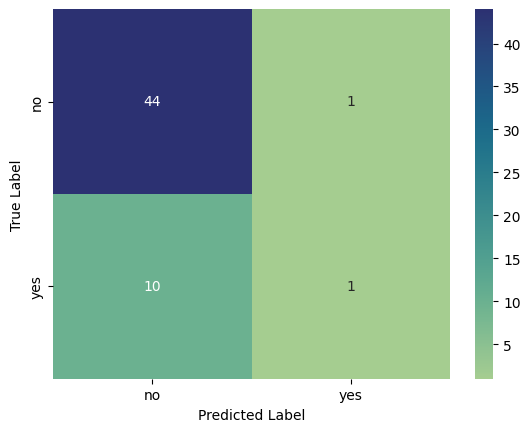

In [125]:
confusions(y_test, y_pred)

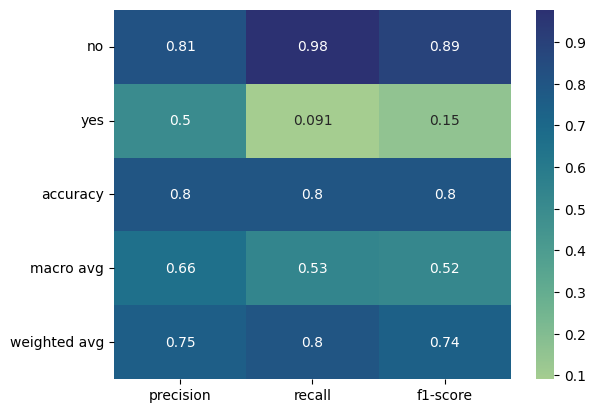

In [126]:
report(y_test, y_pred)

Model osiągnął accuracy na poziomie 82%, to mniej niż model, który zwracał zawsze klasę 'no' (XD). To nie najlepiej, jednak zważając na niezbilansowanie danego datasetu, nie jest to najgorszy wynik.